In [1]:
import hoomd
import freud
import schmeud
import gsd.hoomd

import matplotlib.pyplot as plt
import numpy as np

from monk import prep, methods, pair, render, nb

In [11]:
temp = 3e-4
S = 1.0
Sxy = 3e-3

In [12]:
sim = prep.quick_sim(256, 0.5, hoomd.device.CPU(), dim=2)
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=temp)

In [13]:
integrator = hoomd.md.Integrator(dt=0.01)

nlist = hoomd.md.nlist.Cell(0.3)
hertz = pair.bi_hertz(nlist)
# drag = methods.SimpleViscousForce(1.0)
integrator.forces = [hertz]

nvt = hoomd.md.methods.NPT(hoomd.filter.All(), kT=temp, tau=1.0, S=[S, S, 0.0, 0.0, 0.0, -Sxy], tauS=1.2, couple="xy", box_dof=[True, True, False, True, False, False], gamma=0.1)
integrator.methods.append(nvt)

sim.operations.integrator = integrator

thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
logger = hoomd.logging.Logger()
logger.add(thermo, quantities=["pressure", "pressure_tensor", "kinetic_temperature"])
sim.operations.computes.clear()
sim.operations.computes.append(thermo)

gsd_writer = hoomd.write.GSD(hoomd.trigger.Periodic(1000), "test.gsd", mode="wb", log=logger)
sim.operations.writers.clear()
sim.operations.writers.append(gsd_writer)

action = methods.KeepBoxTiltsSmall()
updater = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(10), action)
sim.operations.updaters.clear()
sim.operations.updaters.append(updater)

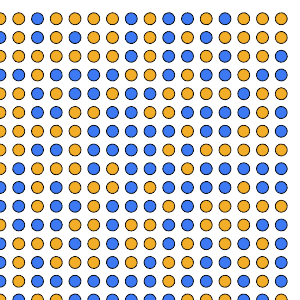

In [14]:
render.render_disk_frame(sim.state.get_snapshot())

In [34]:
sim.run(1000_000)

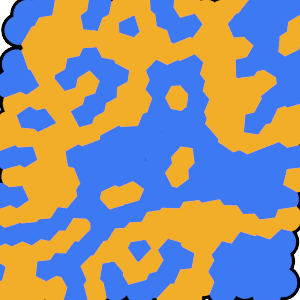

In [21]:
render.render_disk_frame(sim.state.get_snapshot())

In [22]:
sim.state.box

hoomd.box.Box(Lx=8.31621265411377, Ly=8.31621265411377, Lz=0.0, xy=0.11060553044080734, xz=0.0, yz=0.0)

In [35]:
traj = gsd.hoomd.open("test.gsd", "rb")

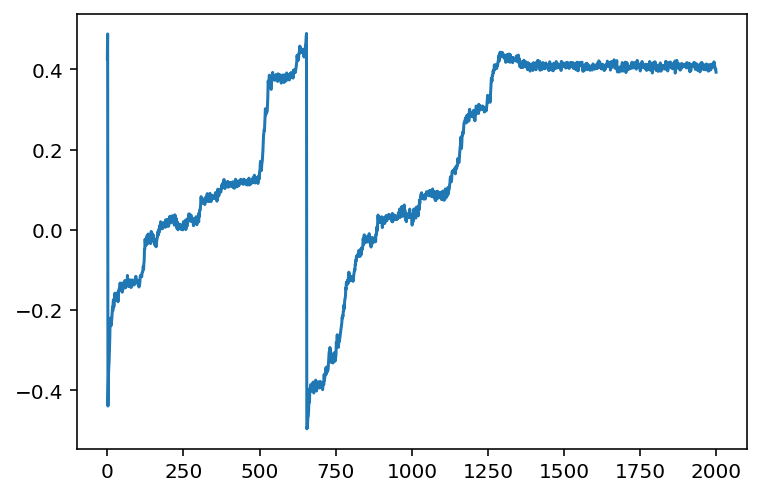

In [36]:
xy = [snap.configuration.box[3] for snap in traj]
plt.plot(xy)

In [37]:
traj[0].log

{'md/compute/ThermodynamicQuantities/pressure': array([1.0000118]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 1.00366735, -0.0028341 ,  0.        ,  0.99635625,  0.        ,
         0.        ]),
 'md/compute/ThermodynamicQuantities/kinetic_temperature': array([0.00031752])}

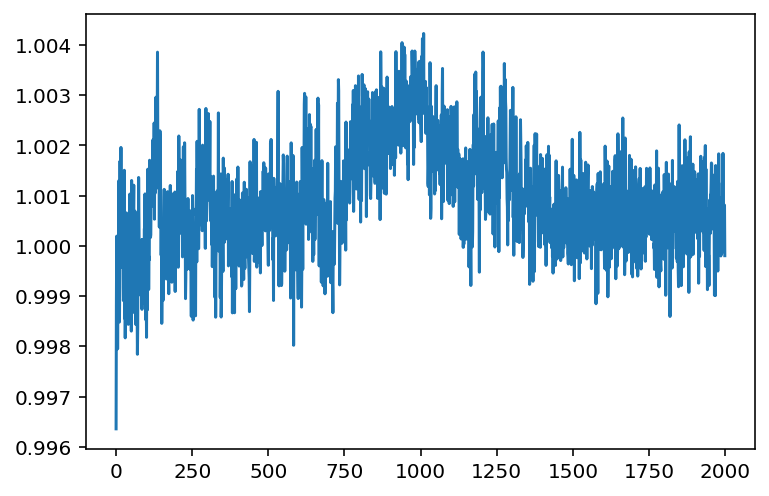

In [38]:
sigma_xy = [snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][3] for snap in traj]
plt.plot(sigma_xy)

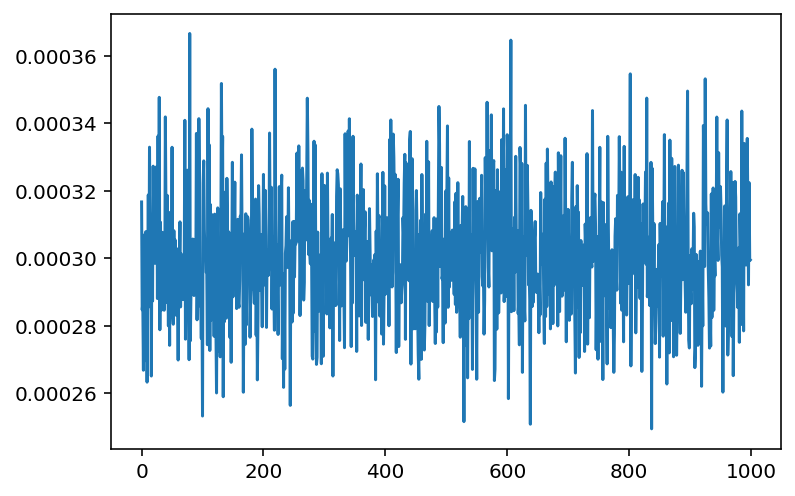

In [10]:
kin_temps = [snap.log["md/compute/ThermodynamicQuantities/kinetic_temperature"] for snap in traj]
plt.plot(kin_temps)